# Synthetic Image Generator for YOLOv2.1

This notebook generates synthetic images for the training, validation and testing. The output of this notebook is required by the **Training+Export.ipynb** notebook.

Authors(s): *Martin Fränzl*

## Required packages

In [18]:
import numpy as np
pi = np.pi
import matplotlib.pyplot as plt
%matplotlib inline

import os
import matplotlib.patches as patches

from tqdm import tqdm # Progress bar

from xml_writer import Writer # Writes XML files in the Pascal VOC format 
import image_generator as ig 

## Function definitions

In [19]:
def rotate(origin, point, angle):
    x0, y0 = origin
    x1, y1 = point
    x2 = x0 + np.cos(angle)*(x1 - x0) - np.sin(angle)*(y1 - y0)
    y2 = y0 - np.sin(angle)*(x1 - x0) - np.cos(angle)*(y1 - y0)
    return x2, y2

## Display single image for parameter adjustments

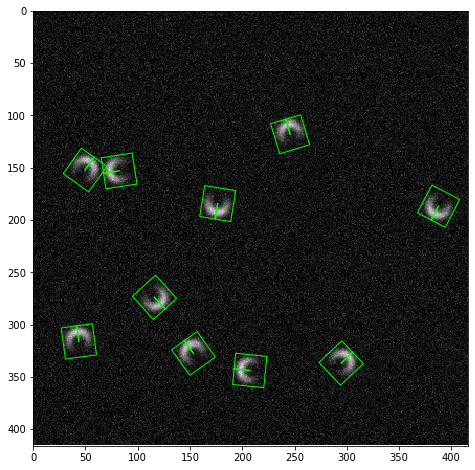

In [20]:
image_w = 416
image_h = 416
n_list = [1, 15]
label_list = 'Janus' 
color_list = ['lime']
parameters_list= [[[1], [9], [3]]] 
snr_range = [1, 30]
i_range = [0.1, 1]
distance = 15
offset = 15

objects = ig.getRandom(1, np.random.randint(n_list[0], n_list[1] + 1), image_w, image_h, distance, offset, label_list, parameters_list)[0]

bboxes, labels, image = ig.generateImage(objects, image_w, image_h, snr_range, i_range)

fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.imshow(image, cmap='gray')
for bbox, label in zip(bboxes, labels):
    xmin, ymin = bbox[0]
    xmax, ymax = bbox[1]
    w, h = xmax - xmin, ymax - ymin 
    x0, y0 =  xmin + w/2, ymin + h/2
    angle = 2*pi*bbox[2]
    ax.add_patch(patches.Polygon([rotate((x0, y0), (xmin, ymin), angle), rotate((x0, y0), (xmax, ymin), angle), rotate((x0, y0), (xmax, ymax), angle), rotate((x0, y0), (xmin, ymax), angle)], linewidth=1, edgecolor=color_list[np.where(np.array(label_list) == label)[0][0]], facecolor='none'))
    ax.plot([x0, x0 + 0.5*w*np.cos(angle)], [y0, y0 - 0.5*w*np.sin(angle)], '-', c=color_list[np.where(np.array(label_list) == label)[0][0]])
    
ax.set_xlim(0, image_w)
ax.set_ylim(image_h, 0)
plt.show()

## Generate images for training, validation and testing

In [22]:
subdir = 'Dataset/' 
nimages = [25000, 2500, 100]
folders = ['train', 'valid', 'test']

if not os.path.exists(subdir):
    os.mkdir(subdir)
    
for i, prefix in enumerate(folders):
    
    i_dir = subdir + '/' + prefix + '_images/'
    if not os.path.exists(i_dir):
        os.mkdir(i_dir)
    a_dir = subdir + '/' + prefix + '_annotations/'
    if not os.path.exists(a_dir):
        os.mkdir(a_dir)
    
    for i in tqdm(range(nimages[i])):    
        objects = ig.getRandom(1, np.random.randint(n_list[0], n_list[1] + 1), image_w, image_h, distance, offset, label_list, parameters_list)[0]
        bboxes, labels, image = ig.generateImage(objects, image_w, image_h, snr_range, i_range) 
        fname = i_dir + 'image_{:04d}.jpg'.format(i,2)
        plt.imsave(fname, image, cmap='gray')
        writer = Writer(fname, image_w, image_h)
        for bbox, label in zip(bboxes, labels):
            xmin, ymin = bbox[0]
            xmax, ymax = bbox[1]
            theta = bbox[2]
            writer.addObject(label, xmin, ymin, xmax, ymax, theta)
        xmlname = a_dir + 'image_{:04d}.xml'.format(i,2)    
        writer.save(xmlname)
        
ig.exportConfig(subdir + 'info.txt', nimages, label_list, parameters_list, n_list, snr_range, i_range, distance, offset)

100%|██████████| 100/100 [00:18<00:00,  5.31it/s]
